<a href="https://colab.research.google.com/github/fun-debug/demo/blob/main/d2l/recurrent-neurl-networks/rnn_concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install d2l==0.17.6

  Using cached d2l-0.17.6-py3-none-any.whl (112 kB)
  Attempting uninstall: d2l
    Found existing installation: d2l 0.16.0
    Uninstalling d2l-0.16.0:
      Successfully uninstalled d2l-0.16.0


In [27]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 定义模型

In [28]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [29]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [30]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [31]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel,self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens),device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens),device=device))

## 训练与预测

In [32]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size = len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerfaaxguaxgu'

TypeError: ignored

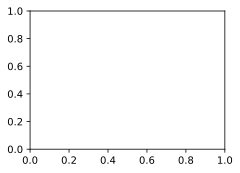

In [34]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)